There are two ways how to classify the sentence. First is to translate the sentence to english and use the models 1-4 together to classify translated sentence. Other way is to use the model 5 which is trained on the multilingual data. So let's compare the two approaches, by using completely new data for the models.

Because I teached model 5 not on the whole data(only on 60%) it is important to compare the models on completely new data.

In [3]:
import pandas as pd
from final_decission_script import classify_comment
from langdetect import detect
from deep_translator import GoogleTranslator
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

## Read the data

In [4]:
data = pd.read_csv('..\data\Multiilingual_dataset\mulilingual_dataset.csv')

In [5]:
data1 = data.sample(frac=0.6, random_state=42)
data = data.drop(data1.index)
data = data.sample(frac=0.01, random_state=42)

In [6]:
data = data.dropna()

In [7]:
data["label"] = data["label"].astype(int)

In [8]:
data["text"] = data["text"].astype(str)

In [78]:
data.head()

,text,label
303016,ヨガマットとくつ下はしっかりくっついていて滑らないが、足だけがすべり結果くつ下がずり脱げる。...,2
1026641,写真とは違い、ストラップではなく取っ手が付いているものでした。 発泡スチロールのような素材で...,1
1766391,"Estamos muy contentos con este producto, sufic...",2
1579838,...Billigst verarbeitet... hab mich beim Zusam...,0
327249,漫长的亚马逊物流22日拍的29日还没有收到！熬心呀！,0


## Predictions with models 1-4 and transation to english

In [ ]:
data_translate = data.copy()

In [ ]:
data_translate = data_translate.iloc[:200]

In [ ]:
def predict_multilingual(text):
    try:
        if detect(text) != 'en': 
            text = GoogleTranslator(source='auto', target='en').translate(text)
        sentiment = classify_comment(text)  
        return int({'Negative': 0, 'Neutral': 1, 'Positive': 2}[sentiment])
    except Exception as e:
        return None  

In [ ]:
import time

start_time = time.time()
data_translate["predicted_label"] = data_translate["text"].apply(predict_multilingual)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 80.37998294830322 seconds


Due to translation of each sentence to english, it takes too long time for only 200 sentences.

In [ ]:
data_translate.dropna(inplace=True)

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(data_translate['label'], data_translate['predicted_label'])
class_report = classification_report(data_translate['label'], data_translate['predicted_label'], target_names=['Negative', 'Neutral', 'Positive'])

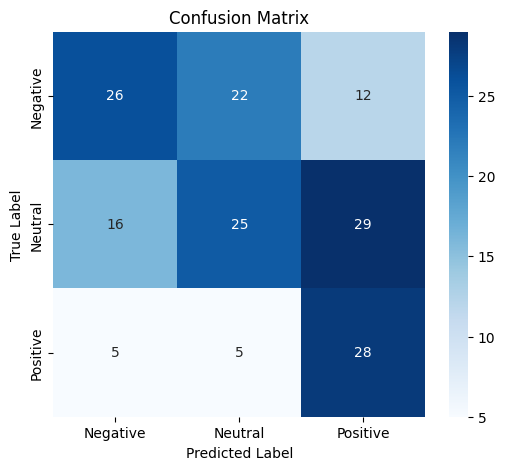

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Display classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.55      0.43      0.49        60
     Neutral       0.48      0.36      0.41        70
    Positive       0.41      0.74      0.52        38

    accuracy                           0.47       168
   macro avg       0.48      0.51      0.47       168
weighted avg       0.49      0.47      0.46       168



Results with translation to english are very bad, accuracy 47% says that the model is not able to classify the sentence correctly, so the approach with translation to english is not good.

## Predictions with model 5

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_path = "model5/model5/"
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

In [2]:
def predict_sentiment(text):
    loaded_model.eval()
    
    # Tokenize input text
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move to device
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class  

In [9]:
data_model5 = data.copy()
data_model5 = data_model5.iloc[:200]

In [16]:
import time
start_time = time.time()
data_model5["predicted_label"] = data_model5["text"].apply(predict_sentiment)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 1.384558916091919 seconds


Predictions with model5 took much less time than translation to english.

In [17]:
conf_matrix = confusion_matrix(data_model5['label'], data_model5['predicted_label'])
class_report = classification_report(data_model5['label'], data_model5['predicted_label'], target_names=['Negative', 'Neutral', 'Positive'])

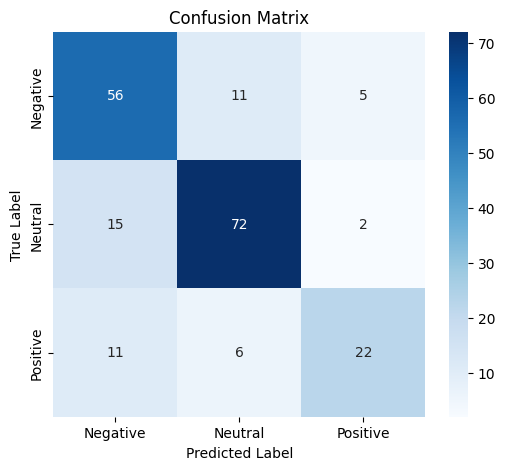

In [18]:
# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Display classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.78      0.73        72
     Neutral       0.81      0.81      0.81        89
    Positive       0.76      0.56      0.65        39

    accuracy                           0.75       200
   macro avg       0.75      0.72      0.73       200
weighted avg       0.75      0.75      0.75       200



Model 5 showed much better results than models 1-4 with translation, so in app I will use model 5 for classification of the sentences.